# ViT CIFAR-10
load timm ViT and retrain on CIFAR 10

In [1]:
NOQUANT_TRAIN = False

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 224

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

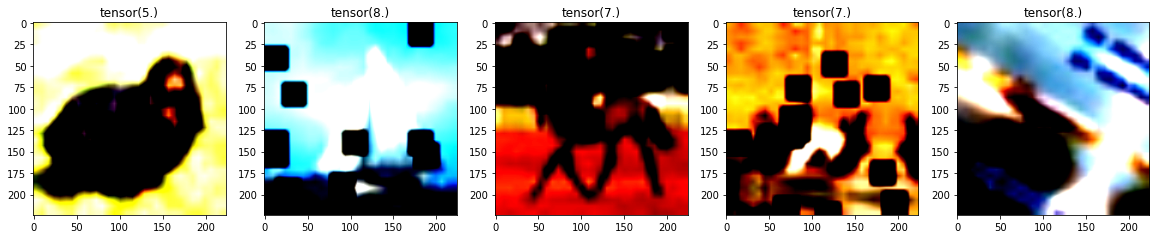

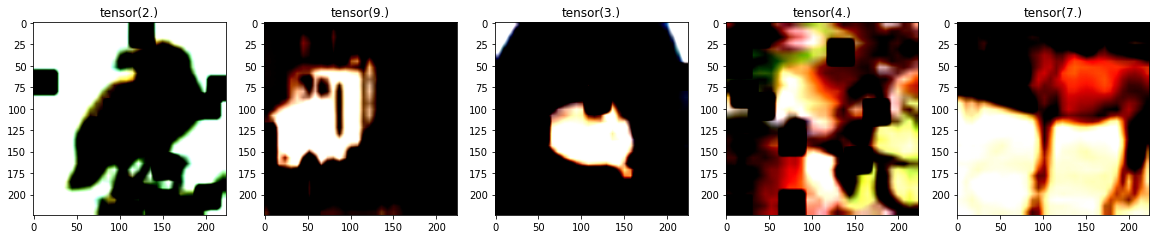

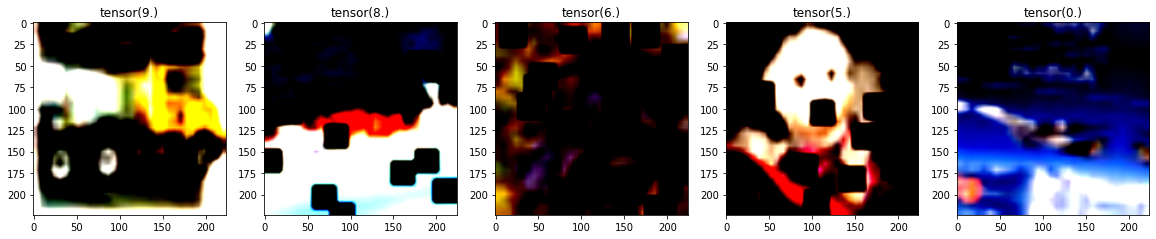

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
import timm
net = timm.create_model("vit_small_patch16_224", pretrained=True)
net.head = nn.Linear(net.head.in_features, 10)

# Train VIT without quantization

In [10]:
model = net.cuda()
mixup = False

import wandb
watermark = "vit_small_noquant"
wandb.init(project="pact_vit",
            name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                            momentum=0.9,
                            weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=[80, 150],)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

if NOQUANT_TRAIN:
    for epoch in range(10):
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin


# Train with quantization

In [11]:
from module import ActFn

# For activation quantization
class Activation(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.ActFn = ActFn.apply
        self.k = k
        self.alpha = nn.Parameter(torch.tensor(10.))
    
    def forward(self, x):
        return self.ActFn(x, self.alpha, self.k)

In [12]:
# have fun with timm models

from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from timm.models.registry import register_model
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, named_apply, adapt_input_conv
from functools import partial
from pact_utils import QuantizedLinear

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., k=8, pact=False):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = QuantizedLinear(in_features, hidden_features, True, k, k, pact)
        self.act = act_layer()
        self.fc2 = QuantizedLinear(hidden_features, out_features, True, k, k, pact)
        self.drop = nn.Dropout(drop)
        
        # PACT
        self.k = k
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., k=8, pact=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = QuantizedLinear(dim, dim * 3, qkv_bias, k, k, pact)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = QuantizedLinear(dim, dim, True, k, k, pact)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # PACT
        #self.alpha1 = nn.Parameter(torch.tensor(2.))
        #self.alpha2 = nn.Parameter(torch.tensor(2.))
        #self.alpha3 = nn.Parameter(torch.tensor(2.))
        #self.alpha4 = nn.Parameter(torch.tensor(2.))
        #self.quant = ActFn.apply
        self.k = k

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, k=8, pact=False, attenk=5):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, k=attenk, pact=pact)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, k=k)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init='', k=8, pact=False, attenk=5):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer, k=k, pact=pact, attenk=attenk)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


@torch.no_grad()
def _load_weights(model: VisionTransformer, checkpoint_path: str, prefix: str = ''):
    """ Load weights from .npz checkpoints for official Google Brain Flax implementation
    """
    import numpy as np

    def _n2p(w, t=True):
        if w.ndim == 4 and w.shape[0] == w.shape[1] == w.shape[2] == 1:
            w = w.flatten()
        if t:
            if w.ndim == 4:
                w = w.transpose([3, 2, 0, 1])
            elif w.ndim == 3:
                w = w.transpose([2, 0, 1])
            elif w.ndim == 2:
                w = w.transpose([1, 0])
        return torch.from_numpy(w)

    w = np.load(checkpoint_path)
    if not prefix and 'opt/target/embedding/kernel' in w:
        prefix = 'opt/target/'

    if hasattr(model.patch_embed, 'backbone'):
        # hybrid
        backbone = model.patch_embed.backbone
        stem_only = not hasattr(backbone, 'stem')
        stem = backbone if stem_only else backbone.stem
        stem.conv.weight.copy_(adapt_input_conv(stem.conv.weight.shape[1], _n2p(w[f'{prefix}conv_root/kernel'])))
        stem.norm.weight.copy_(_n2p(w[f'{prefix}gn_root/scale']))
        stem.norm.bias.copy_(_n2p(w[f'{prefix}gn_root/bias']))
        if not stem_only:
            for i, stage in enumerate(backbone.stages):
                for j, block in enumerate(stage.blocks):
                    bp = f'{prefix}block{i + 1}/unit{j + 1}/'
                    for r in range(3):
                        getattr(block, f'conv{r + 1}').weight.copy_(_n2p(w[f'{bp}conv{r + 1}/kernel']))
                        getattr(block, f'norm{r + 1}').weight.copy_(_n2p(w[f'{bp}gn{r + 1}/scale']))
                        getattr(block, f'norm{r + 1}').bias.copy_(_n2p(w[f'{bp}gn{r + 1}/bias']))
                    if block.downsample is not None:
                        block.downsample.conv.weight.copy_(_n2p(w[f'{bp}conv_proj/kernel']))
                        block.downsample.norm.weight.copy_(_n2p(w[f'{bp}gn_proj/scale']))
                        block.downsample.norm.bias.copy_(_n2p(w[f'{bp}gn_proj/bias']))
        embed_conv_w = _n2p(w[f'{prefix}embedding/kernel'])
    else:
        embed_conv_w = adapt_input_conv(
            model.patch_embed.proj.weight.shape[1], _n2p(w[f'{prefix}embedding/kernel']))
    model.patch_embed.proj.weight.copy_(embed_conv_w)
    model.patch_embed.proj.bias.copy_(_n2p(w[f'{prefix}embedding/bias']))
    model.cls_token.copy_(_n2p(w[f'{prefix}cls'], t=False))
    pos_embed_w = _n2p(w[f'{prefix}Transformer/posembed_input/pos_embedding'], t=False)
    if pos_embed_w.shape != model.pos_embed.shape:
        pos_embed_w = resize_pos_embed(  # resize pos embedding when different size from pretrained weights
            pos_embed_w, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
    model.pos_embed.copy_(pos_embed_w)
    model.norm.weight.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/bias']))
    if isinstance(model.head, nn.Linear) and model.head.bias.shape[0] == w[f'{prefix}head/bias'].shape[-1]:
        model.head.weight.copy_(_n2p(w[f'{prefix}head/kernel']))
        model.head.bias.copy_(_n2p(w[f'{prefix}head/bias']))
    if isinstance(getattr(model.pre_logits, 'fc', None), nn.Linear) and f'{prefix}pre_logits/bias' in w:
        model.pre_logits.fc.weight.copy_(_n2p(w[f'{prefix}pre_logits/kernel']))
        model.pre_logits.fc.bias.copy_(_n2p(w[f'{prefix}pre_logits/bias']))
    for i, block in enumerate(model.blocks.children()):
        block_prefix = f'{prefix}Transformer/encoderblock_{i}/'
        mha_prefix = block_prefix + 'MultiHeadDotProductAttention_1/'
        block.norm1.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/scale']))
        block.norm1.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/bias']))
        block.attn.qkv.weight.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/kernel'], t=False).flatten(1).T for n in ('query', 'key', 'value')]))
        block.attn.qkv.bias.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/bias'], t=False).reshape(-1) for n in ('query', 'key', 'value')]))
        block.attn.proj.weight.copy_(_n2p(w[f'{mha_prefix}out/kernel']).flatten(1))
        block.attn.proj.bias.copy_(_n2p(w[f'{mha_prefix}out/bias']))
        for r in range(2):
            getattr(block.mlp, f'fc{r + 1}').weight.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/kernel']))
            getattr(block.mlp, f'fc{r + 1}').bias.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/bias']))
        block.norm2.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/scale']))
        block.norm2.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/bias']))


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, default_cfg=None, **kwargs):
    default_cfg = default_cfg or default_cfgs[variant]
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    # NOTE this extra code to support handling of repr size for in21k pretrained models
    default_num_classes = default_cfg['num_classes']
    num_classes = kwargs.get('num_classes', default_num_classes)
    repr_size = kwargs.pop('representation_size', None)
    if repr_size is not None and num_classes != default_num_classes:
        # Remove representation layer if fine-tuning. This may not always be the desired action,
        # but I feel better than doing nothing by default for fine-tuning. Perhaps a better interface?
        _logger.warning("Removing representation layer for fine-tuning.")
        repr_size = None

    model = build_model_with_cfg(
        VisionTransformer, variant, pretrained,
        default_cfg=default_cfg,
        representation_size=repr_size,
        pretrained_filter_fn=checkpoint_filter_fn,
        pretrained_custom_load='npz' in default_cfg['url'],
        **kwargs)
    return model

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }

default_cfgs = {
    # patch models (weights from official Google JAX impl)
    'vit_tiny_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    }

@register_model
def vit_tiny_patch16_224(pretrained=False, k=8, pact=False, **kwargs):
    """ ViT-Tiny (Vit-Ti/16)
    """
    model_kwargs = dict(patch_size=16, embed_dim=192, depth=12, num_heads=3, k=k, pact=pact, **kwargs)
    model = _create_vision_transformer('vit_tiny_patch16_224', pretrained=pretrained, **model_kwargs)
    return model

@register_model
def vit_small_patch16_224(pretrained=False, k=8, **kwargs):
    """ ViT-Small (ViT-S/16)
    NOTE I've replaced my previous 'small' model definition and weights with the small variant from the DeiT paper
    """
    model_kwargs = dict(patch_size=16, embed_dim=384, depth=12, num_heads=6, k=k, **kwargs)
    model = _create_vision_transformer('vit_small_patch16_224', pretrained=pretrained, **model_kwargs)
    return model


In [ ]:
from timm.scheduler import CosineLRScheduler

for PACT in [False, True]:
    for attenk in [4,5,6]:
        for k in [6,7]:
            net = vit_small_patch16_224(True, k=k, attenk=attenk, pact=PACT)
            net.head = nn.Linear(net.head.in_features, 10)
            checkpoint = torch.load("models/vit_small_noquant.pth")
            net.load_state_dict(checkpoint, strict=False)

            model = net.cuda()
            mixup = False

            # Track experiment with wandb
            import wandb
            watermark = "vit_small_k{}_attenk{}".format(k, attenk)
            if PACT == False:
                watermark+="_nopact"
            else:
                watermark+="_pact"

            # mess with wandb
            wandb.init(project="pact_vit_20220617", name=watermark)

            # define loss function (criterion) and pptimizer
            criterion = nn.CrossEntropyLoss().cuda()

            # optimizer for pact
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                        momentum=0.9,
                                        weight_decay=0.0002)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

            scheduler = CosineLRScheduler(optimizer, t_initial=10, lr_min=1e-6, 
                                  warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

            best_prec1 = 0
            os.makedirs("models", exist_ok=True)

            for epoch in range(10):
                scheduler.step(epoch)
                # train for one epoch
                print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
                tloss = train(train_loader, model, criterion, optimizer, epoch)         

                # evaluate on validation set
                prec1, valloss = validate(val_loader, model, criterion)

                # wandb
                wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

                # remember best prec@1 and save checkpoint
                is_best = prec1 > best_prec1
                best_prec1 = max(prec1, best_prec1)

                print("Best prec1 : ", best_prec1)
                if is_best:
                    torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 4.533 (4.533)	Data 1.639 (1.639)	Loss 0.9266 (0.9266)	Prec@1 67.578 (67.578)
Epoch: [0][50/157]	Time 0.844 (0.915)	Data 0.001 (0.033)	Loss 0.6217 (0.7392)	Prec@1 78.125 (74.073)
Epoch: [0][100/157]	Time 0.847 (0.881)	Data 0.001 (0.017)	Loss 0.5353 (0.6633)	Prec@1 80.078 (76.787)
Epoch: [0][150/157]	Time 0.847 (0.870)	Data 0.001 (0.012)	Loss 0.5416 (0.6180)	Prec@1 80.469 (78.404)
Test: [0/20]	Time 2.605 (2.605)	Loss 0.1986 (0.1986)	Prec@1 92.383 (92.383)
 * Prec@1 92.180
Best prec1 :  92.18000002441406
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 2.101 (2.101)	Data 1.256 (1.256)	Loss 0.4958 (0.4958)	Prec@1 82.031 (82.031)
Epoch: [1][50/157]	Time 0.847 (0.872)	Data 0.001 (0.026)	Loss 0.4498 (0.4648)	Prec@1 83.203 (83.709)
Epoch: [1][100/157]	Time 0.848 (0.860)	Data 0.001 (0.013)	Loss 0.4582 (0.4486)	Prec@1 84.766 (84.182)
Epoch: [1][150/157]	Time 0.847 (0.856)	Data 0.001 (0.009)	Loss 0.4105 (0.4340)	Prec@1 87.109 (84.789)
Test: [0/20]	Time 2.994 (2.994)	Loss 0.1308 (0.1308)	Prec@1 96.094 (96.094)
 * Prec@1 94.430
Best prec1 :  94.4300000366211
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.222 (2.222)	Data 1.379 (1.379)	Loss 0.4109 (0.4109)	Prec@1 85.156 (85.156)
Epoch: [2][50/157]	Time 0.844 (0.879)	Data 0.001 (0.038)	Loss 0.3431 (0.3928)	Prec@1 88.281 (86.137)
Epoch: [2][100/157]	Time 0.846 (0.862)	Data 0.001 (0.020)	Loss 0.3680 (0.3814)	Prec@1 85.938 (86.444)
Epoch: [2][150/157]	Time 0.847 (0.857)	Data 0.001 (0.013)	Loss 0.3765 (0.3781)	Prec@1 86.328 (86.664)
Test: [0/20]	Time 2.355 (2.355)	Loss 0.1126 (0.1126)	Prec@1 95.703 (95.703)
 * Prec@1 95.280
Best prec1 :  95.27999995117187
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.857 (1.857)	Data 1.009 (1.009)	Loss 0.3283 (0.3283)	Prec@1 89.062 (89.062)
Epoch: [3][50/157]	Time 0.847 (0.867)	Data 0.001 (0.021)	Loss 0.3792 (0.3583)	Prec@1 86.328 (87.354)
Epoch: [3][100/157]	Time 0.848 (0.857)	Data 0.001 (0.011)	Loss 0.3359 (0.3599)	Prec@1 87.109 (87.268)
Epoch: [3][150/157]	Time 0.848 (0.854)	Data 0.001 (0.008)	Loss 0.3330 (0.3524)	Prec@1 89.062 (87.567)
Test: [0/20]	Time 2.452 (2.452)	Loss 0.1060 (0.1060)	Prec@1 96.094 (96.094)
 * Prec@1 95.780
Best prec1 :  95.78000004882813
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.580 (1.580)	Data 0.729 (0.729)	Loss 0.3744 (0.3744)	Prec@1 85.938 (85.938)
Epoch: [4][50/157]	Time 0.847 (0.862)	Data 0.001 (0.015)	Loss 0.3867 (0.3135)	Prec@1 87.500 (88.909)
Epoch: [4][100/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.4265 (0.3180)	Prec@1 85.156 (88.761)
Epoch: [4][150/157]	Time 0.847 (0.853)	Data 0.001 (0.006)	Loss 0.2172 (0.3153)	Prec@1 92.969 (88.959)
Test: [0/20]	Time 2.159 (2.159)	Loss 0.0958 (0.0958)	Prec@1 97.070 (97.070)
 * Prec@1 96.110
Best prec1 :  96.11000002441406
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 2.105 (2.105)	Data 1.258 (1.258)	Loss 0.2323 (0.2323)	Prec@1 92.188 (92.188)
Epoch: [5][50/157]	Time 0.847 (0.872)	Data 0.001 (0.026)	Loss 0.2785 (0.3082)	Prec@1 91.406 (89.239)
Epoch: [5][100/157]	Time 0.847 (0.860)	Data 0.001 (0.013)	Loss 0.3086 (0.3066)	Prec@1 89.453 (89.387)
Epoch: [5][150/157]	Time 0.847 (0.856)	Data 0.001 (0.009)	Loss 0.2284 (0.3011)	Prec@1 91.406 (89.479)
Test: [0/20]	Time 2.150 (2.150)	Loss 0.0796 (0.0796)	Prec@1 97.266 (97.266)
 * Prec@1 96.440
Best prec1 :  96.43999991455078
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 2.087 (2.087)	Data 1.237 (1.237)	Loss 0.3515 (0.3515)	Prec@1 87.500 (87.500)
Epoch: [6][50/157]	Time 0.847 (0.870)	Data 0.001 (0.025)	Loss 0.2812 (0.2901)	Prec@1 88.281 (89.714)
Epoch: [6][100/157]	Time 0.847 (0.858)	Data 0.001 (0.013)	Loss 0.2693 (0.2864)	Prec@1 90.625 (89.906)
Epoch: [6][150/157]	Time 0.847 (0.855)	Data 0.001 (0.009)	Loss 0.1969 (0.2852)	Prec@1 92.969 (89.963)
Test: [0/20]	Time 51.131 (51.131)	Loss 0.0920 (0.0920)	Prec@1 97.070 (97.070)
 * Prec@1 96.380
Best prec1 :  96.43999991455078
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 2.112 (2.112)	Data 1.269 (1.269)	Loss 0.2241 (0.2241)	Prec@1 91.016 (91.016)
Epoch: [7][50/157]	Time 0.844 (0.867)	Data 0.001 (0.026)	Loss 0.2408 (0.2634)	Prec@1 91.406 (90.771)
Epoch: [7][100/157]	Time 0.846 (0.856)	Data 0.001 (0.014)	Loss 0.3269 (0.2684)	Prec@1 89.062 (90.586)
Epoch: [7][150/157]	Time 0.846 (0.853)	Data 0.001 (0.009)	Loss 0.2827 (0.2664)	Prec@1 91.016 (90.620)
Test: [0/20]	Time 2.513 (2.513)	Loss 0.0643 (0.0643)	Prec@1 98.438 (98.438)
 * Prec@1 96.440
Best prec1 :  96.43999991455078
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.814 (1.814)	Data 0.965 (0.965)	Loss 0.2313 (0.2313)	Prec@1 91.797 (91.797)
Epoch: [8][50/157]	Time 0.847 (0.866)	Data 0.001 (0.020)	Loss 0.2199 (0.2559)	Prec@1 94.141 (90.977)
Epoch: [8][100/157]	Time 0.847 (0.857)	Data 0.001 (0.011)	Loss 0.1951 (0.2593)	Prec@1 92.969 (90.985)
Epoch: [8][150/157]	Time 0.847 (0.854)	Data 0.001 (0.007)	Loss 0.2431 (0.2623)	Prec@1 90.625 (90.840)
Test: [0/20]	Time 2.127 (2.127)	Loss 0.0622 (0.0622)	Prec@1 98.047 (98.047)
 * Prec@1 96.550
Best prec1 :  96.54999986572265
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.953 (1.953)	Data 1.104 (1.104)	Loss 0.2556 (0.2556)	Prec@1 92.188 (92.188)
Epoch: [9][50/157]	Time 0.847 (0.869)	Data 0.001 (0.023)	Loss 0.3418 (0.2542)	Prec@1 88.672 (91.131)
Epoch: [9][100/157]	Time 0.847 (0.858)	Data 0.001 (0.012)	Loss 0.2978 (0.2527)	Prec@1 89.062 (91.170)
Epoch: [9][150/157]	Time 0.848 (0.854)	Data 0.001 (0.008)	Loss 0.3112 (0.2518)	Prec@1 91.406 (91.127)
Test: [0/20]	Time 2.545 (2.545)	Loss 0.0806 (0.0806)	Prec@1 97.656 (97.656)
 * Prec@1 96.520
Best prec1 :  96.54999986572265


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▅▆▇▇█████
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
lr,0.0
prec,96.52
train_loss,0.25215
val_loss,0.09839


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.713 (1.713)	Data 0.864 (0.864)	Loss 0.5736 (0.5736)	Prec@1 80.859 (80.859)
Epoch: [0][50/157]	Time 0.847 (0.863)	Data 0.001 (0.018)	Loss 0.4031 (0.5166)	Prec@1 84.375 (82.391)
Epoch: [0][100/157]	Time 0.848 (0.855)	Data 0.001 (0.010)	Loss 0.3832 (0.4685)	Prec@1 87.891 (83.868)
Epoch: [0][150/157]	Time 0.847 (0.853)	Data 0.001 (0.007)	Loss 0.4126 (0.4450)	Prec@1 87.109 (84.497)
Test: [0/20]	Time 2.423 (2.423)	Loss 0.1340 (0.1340)	Prec@1 95.898 (95.898)
 * Prec@1 94.400
Best prec1 :  94.39999993896484
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.966 (1.966)	Data 1.117 (1.117)	Loss 0.4701 (0.4701)	Prec@1 82.812 (82.812)
Epoch: [1][50/157]	Time 0.848 (0.870)	Data 0.001 (0.023)	Loss 0.2914 (0.3980)	Prec@1 88.672 (86.037)
Epoch: [1][100/157]	Time 0.848 (0.859)	Data 0.001 (0.012)	Loss 0.3611 (0.3824)	Prec@1 88.672 (86.560)
Epoch: [1][150/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.3230 (0.3698)	Prec@1 89.844 (87.008)
Test: [0/20]	Time 2.061 (2.061)	Loss 0.1196 (0.1196)	Prec@1 95.898 (95.898)
 * Prec@1 95.530
Best prec1 :  95.53000001220703
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.804 (1.804)	Data 0.954 (0.954)	Loss 0.3484 (0.3484)	Prec@1 88.281 (88.281)
Epoch: [2][50/157]	Time 0.848 (0.866)	Data 0.001 (0.020)	Loss 0.2763 (0.3373)	Prec@1 90.234 (88.128)
Epoch: [2][100/157]	Time 0.848 (0.857)	Data 0.001 (0.010)	Loss 0.3417 (0.3328)	Prec@1 87.891 (88.359)
Epoch: [2][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.4158 (0.3327)	Prec@1 86.719 (88.372)
Test: [0/20]	Time 1.899 (1.899)	Loss 0.1188 (0.1188)	Prec@1 95.508 (95.508)
 * Prec@1 95.660
Best prec1 :  95.65999998779297
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.071 (2.071)	Data 1.227 (1.227)	Loss 0.2415 (0.2415)	Prec@1 91.797 (91.797)
Epoch: [3][50/157]	Time 0.845 (0.867)	Data 0.001 (0.025)	Loss 0.3482 (0.3092)	Prec@1 87.500 (89.177)
Epoch: [3][100/157]	Time 0.847 (0.857)	Data 0.001 (0.013)	Loss 0.2773 (0.3123)	Prec@1 91.797 (88.962)
Epoch: [3][150/157]	Time 0.848 (0.854)	Data 0.001 (0.009)	Loss 0.3897 (0.3117)	Prec@1 87.109 (89.088)
Test: [0/20]	Time 1.948 (1.948)	Loss 0.0985 (0.0985)	Prec@1 97.070 (97.070)
 * Prec@1 96.410
Best prec1 :  96.41000001220704
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.879 (1.879)	Data 1.029 (1.029)	Loss 0.2453 (0.2453)	Prec@1 89.453 (89.453)
Epoch: [4][50/157]	Time 0.847 (0.868)	Data 0.001 (0.021)	Loss 0.2578 (0.3102)	Prec@1 91.797 (88.879)
Epoch: [4][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.2731 (0.2979)	Prec@1 88.281 (89.453)
Epoch: [4][150/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.2795 (0.2942)	Prec@1 90.625 (89.580)
Test: [0/20]	Time 1.965 (1.965)	Loss 0.0840 (0.0840)	Prec@1 97.266 (97.266)
 * Prec@1 96.080
Best prec1 :  96.41000001220704
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.778 (1.778)	Data 0.927 (0.927)	Loss 0.2946 (0.2946)	Prec@1 91.016 (91.016)
Epoch: [5][50/157]	Time 0.848 (0.866)	Data 0.001 (0.019)	Loss 0.2486 (0.2630)	Prec@1 92.188 (90.709)
Epoch: [5][100/157]	Time 0.848 (0.857)	Data 0.001 (0.010)	Loss 0.3118 (0.2671)	Prec@1 88.672 (90.637)
Epoch: [5][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.3224 (0.2695)	Prec@1 90.625 (90.584)
Test: [0/20]	Time 1.787 (1.787)	Loss 0.0835 (0.0835)	Prec@1 97.461 (97.461)
 * Prec@1 96.490
Best prec1 :  96.48999985351563
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.909 (1.909)	Data 1.059 (1.059)	Loss 0.2453 (0.2453)	Prec@1 91.406 (91.406)
Epoch: [6][50/157]	Time 0.848 (0.868)	Data 0.001 (0.022)	Loss 0.2211 (0.2553)	Prec@1 92.188 (91.153)
Epoch: [6][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.1877 (0.2585)	Prec@1 93.750 (90.919)
Epoch: [6][150/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.2367 (0.2605)	Prec@1 91.406 (90.920)
Test: [0/20]	Time 1.924 (1.924)	Loss 0.0812 (0.0812)	Prec@1 97.070 (97.070)
 * Prec@1 96.600
Best prec1 :  96.5999999633789
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.985 (1.985)	Data 1.135 (1.135)	Loss 0.2908 (0.2908)	Prec@1 89.844 (89.844)
Epoch: [7][50/157]	Time 0.848 (0.870)	Data 0.001 (0.023)	Loss 0.2805 (0.2542)	Prec@1 89.062 (91.276)
Epoch: [7][100/157]	Time 0.848 (0.859)	Data 0.001 (0.012)	Loss 0.2467 (0.2499)	Prec@1 91.797 (91.244)
Epoch: [7][150/157]	Time 0.847 (0.855)	Data 0.001 (0.008)	Loss 0.2466 (0.2518)	Prec@1 90.234 (91.236)
Test: [0/20]	Time 2.018 (2.018)	Loss 0.0805 (0.0805)	Prec@1 97.656 (97.656)
 * Prec@1 97.060
Best prec1 :  97.05999986572266
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.955 (1.955)	Data 1.105 (1.105)	Loss 0.2644 (0.2644)	Prec@1 89.844 (89.844)
Epoch: [8][50/157]	Time 0.847 (0.869)	Data 0.001 (0.023)	Loss 0.2285 (0.2379)	Prec@1 90.625 (91.774)
Epoch: [8][100/157]	Time 0.848 (0.859)	Data 0.001 (0.012)	Loss 0.2006 (0.2418)	Prec@1 92.969 (91.646)
Epoch: [8][150/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.1651 (0.2404)	Prec@1 93.750 (91.605)
Test: [0/20]	Time 2.415 (2.415)	Loss 0.0707 (0.0707)	Prec@1 98.242 (98.242)
 * Prec@1 96.960
Best prec1 :  97.05999986572266
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.925 (1.925)	Data 1.076 (1.076)	Loss 0.2541 (0.2541)	Prec@1 89.062 (89.062)
Epoch: [9][50/157]	Time 0.847 (0.869)	Data 0.001 (0.022)	Loss 0.1648 (0.2286)	Prec@1 94.141 (92.073)
Epoch: [9][100/157]	Time 0.848 (0.858)	Data 0.001 (0.012)	Loss 0.2087 (0.2280)	Prec@1 91.406 (92.052)
Epoch: [9][150/157]	Time 0.847 (0.855)	Data 0.001 (0.008)	Loss 0.2197 (0.2278)	Prec@1 89.453 (92.102)
Test: [0/20]	Time 1.754 (1.754)	Loss 0.0763 (0.0763)	Prec@1 98.047 (98.047)
 * Prec@1 97.170
Best prec1 :  97.16999996337891


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▄▄▆▅▆▇█▇█
train_loss,█▆▄▄▃▂▂▂▁▁
val_loss,█▅▅▃▃▂▂▁▁▁
epoch,9
lr,0.0
prec,97.17
train_loss,0.22798
val_loss,0.08743


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.889 (1.889)	Data 1.042 (1.042)	Loss 0.7508 (0.7508)	Prec@1 75.781 (75.781)
Epoch: [0][50/157]	Time 0.846 (0.866)	Data 0.001 (0.021)	Loss 0.4891 (0.5194)	Prec@1 83.984 (81.985)
Epoch: [0][100/157]	Time 0.847 (0.856)	Data 0.001 (0.011)	Loss 0.4238 (0.4677)	Prec@1 86.328 (83.834)
Epoch: [0][150/157]	Time 0.847 (0.853)	Data 0.001 (0.008)	Loss 0.4763 (0.4406)	Prec@1 82.422 (84.698)
Test: [0/20]	Time 1.931 (1.931)	Loss 0.1120 (0.1120)	Prec@1 96.289 (96.289)
 * Prec@1 95.170
Best prec1 :  95.16999995117187
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.713 (1.713)	Data 0.862 (0.862)	Loss 0.3639 (0.3639)	Prec@1 84.766 (84.766)
Epoch: [1][50/157]	Time 0.848 (0.864)	Data 0.001 (0.018)	Loss 0.3517 (0.3580)	Prec@1 88.281 (87.025)
Epoch: [1][100/157]	Time 0.848 (0.856)	Data 0.001 (0.010)	Loss 0.3627 (0.3399)	Prec@1 87.500 (87.829)
Epoch: [1][150/157]	Time 0.848 (0.853)	Data 0.001 (0.007)	Loss 0.2164 (0.3293)	Prec@1 91.016 (88.341)
Test: [0/20]	Time 2.376 (2.376)	Loss 0.0696 (0.0696)	Prec@1 98.242 (98.242)
 * Prec@1 96.490
Best prec1 :  96.48999986572265
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.639 (1.639)	Data 0.780 (0.780)	Loss 0.2598 (0.2598)	Prec@1 90.625 (90.625)
Epoch: [2][50/157]	Time 0.848 (0.863)	Data 0.001 (0.016)	Loss 0.2347 (0.2927)	Prec@1 90.234 (89.614)
Epoch: [2][100/157]	Time 0.848 (0.856)	Data 0.001 (0.009)	Loss 0.2938 (0.2870)	Prec@1 88.672 (89.797)
Epoch: [2][150/157]	Time 0.848 (0.853)	Data 0.001 (0.006)	Loss 0.2507 (0.2875)	Prec@1 92.969 (89.898)
Test: [0/20]	Time 1.947 (1.947)	Loss 0.0664 (0.0664)	Prec@1 98.242 (98.242)
 * Prec@1 97.030
Best prec1 :  97.02999986572266
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.985 (1.985)	Data 1.136 (1.136)	Loss 0.2772 (0.2772)	Prec@1 88.281 (88.281)
Epoch: [3][50/157]	Time 0.847 (0.870)	Data 0.001 (0.023)	Loss 0.3254 (0.2737)	Prec@1 87.891 (90.227)
Epoch: [3][100/157]	Time 0.848 (0.859)	Data 0.001 (0.012)	Loss 0.2319 (0.2712)	Prec@1 92.969 (90.416)
Epoch: [3][150/157]	Time 0.848 (0.855)	Data 0.001 (0.009)	Loss 0.2786 (0.2688)	Prec@1 90.234 (90.516)
Test: [0/20]	Time 1.795 (1.795)	Loss 0.0737 (0.0737)	Prec@1 98.242 (98.242)
 * Prec@1 97.070
Best prec1 :  97.07000002441406
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.756 (1.756)	Data 0.905 (0.905)	Loss 0.3099 (0.3099)	Prec@1 89.844 (89.844)
Epoch: [4][50/157]	Time 0.847 (0.866)	Data 0.001 (0.019)	Loss 0.2200 (0.2640)	Prec@1 91.406 (90.663)
Epoch: [4][100/157]	Time 0.848 (0.857)	Data 0.001 (0.010)	Loss 0.2542 (0.2603)	Prec@1 90.625 (90.737)
Epoch: [4][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.2670 (0.2530)	Prec@1 91.406 (91.031)
Test: [0/20]	Time 2.160 (2.160)	Loss 0.0537 (0.0537)	Prec@1 98.438 (98.438)
 * Prec@1 97.190
Best prec1 :  97.18999991455078
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.602 (1.602)	Data 0.751 (0.751)	Loss 0.2251 (0.2251)	Prec@1 92.188 (92.188)
Epoch: [5][50/157]	Time 0.848 (0.863)	Data 0.001 (0.016)	Loss 0.2267 (0.2434)	Prec@1 91.406 (91.360)
Epoch: [5][100/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.2819 (0.2425)	Prec@1 91.016 (91.472)
Epoch: [5][150/157]	Time 0.848 (0.853)	Data 0.001 (0.006)	Loss 0.2358 (0.2360)	Prec@1 91.406 (91.691)
Test: [0/20]	Time 2.230 (2.230)	Loss 0.0655 (0.0655)	Prec@1 98.242 (98.242)
 * Prec@1 97.210
Best prec1 :  97.20999986572265
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.805 (1.805)	Data 0.954 (0.954)	Loss 0.2728 (0.2728)	Prec@1 90.625 (90.625)
Epoch: [6][50/157]	Time 0.848 (0.866)	Data 0.001 (0.020)	Loss 0.2044 (0.2314)	Prec@1 92.578 (91.782)
Epoch: [6][100/157]	Time 0.848 (0.857)	Data 0.001 (0.010)	Loss 0.2798 (0.2265)	Prec@1 90.625 (91.925)
Epoch: [6][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.2151 (0.2251)	Prec@1 92.969 (91.947)
Test: [0/20]	Time 1.785 (1.785)	Loss 0.0546 (0.0546)	Prec@1 98.438 (98.438)
 * Prec@1 97.080
Best prec1 :  97.20999986572265
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.720 (1.720)	Data 0.864 (0.864)	Loss 0.2272 (0.2272)	Prec@1 91.406 (91.406)
Epoch: [7][50/157]	Time 0.848 (0.865)	Data 0.001 (0.018)	Loss 0.2284 (0.2163)	Prec@1 91.797 (92.486)
Epoch: [7][100/157]	Time 0.847 (0.856)	Data 0.001 (0.010)	Loss 0.1935 (0.2181)	Prec@1 92.969 (92.505)
Epoch: [7][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.2952 (0.2161)	Prec@1 89.062 (92.477)
Test: [0/20]	Time 2.143 (2.143)	Loss 0.0518 (0.0518)	Prec@1 98.633 (98.633)
 * Prec@1 97.200
Best prec1 :  97.20999986572265
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.939 (1.939)	Data 1.091 (1.091)	Loss 0.2847 (0.2847)	Prec@1 91.016 (91.016)
Epoch: [8][50/157]	Time 0.848 (0.869)	Data 0.001 (0.022)	Loss 0.2237 (0.2145)	Prec@1 92.578 (92.433)
Epoch: [8][100/157]	Time 0.848 (0.858)	Data 0.001 (0.012)	Loss 0.1953 (0.2088)	Prec@1 92.969 (92.752)
Epoch: [8][150/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.2617 (0.2091)	Prec@1 92.578 (92.744)
Test: [0/20]	Time 2.689 (2.689)	Loss 0.0551 (0.0551)	Prec@1 98.047 (98.047)
 * Prec@1 97.460
Best prec1 :  97.46000002441406
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 2.068 (2.068)	Data 1.221 (1.221)	Loss 0.1268 (0.1268)	Prec@1 96.484 (96.484)
Epoch: [9][50/157]	Time 0.847 (0.871)	Data 0.001 (0.025)	Loss 0.1727 (0.2079)	Prec@1 94.531 (92.884)
Epoch: [9][100/157]	Time 0.848 (0.860)	Data 0.001 (0.013)	Loss 0.1594 (0.2022)	Prec@1 92.969 (92.926)
Epoch: [9][150/157]	Time 0.848 (0.856)	Data 0.001 (0.009)	Loss 0.2725 (0.2031)	Prec@1 89.844 (92.878)
Test: [0/20]	Time 2.437 (2.437)	Loss 0.0471 (0.0471)	Prec@1 98.438 (98.438)
 * Prec@1 97.670
Best prec1 :  97.67000003662109


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▅▆▆▇▇▆▇▇█
train_loss,█▅▃▃▂▂▂▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁
epoch,9
lr,0.0
prec,97.67
train_loss,0.20298
val_loss,0.07524


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.664 (1.664)	Data 0.816 (0.816)	Loss 0.3638 (0.3638)	Prec@1 86.328 (86.328)
Epoch: [0][50/157]	Time 0.847 (0.862)	Data 0.001 (0.017)	Loss 0.2515 (0.3384)	Prec@1 91.406 (88.496)
Epoch: [0][100/157]	Time 0.848 (0.855)	Data 0.001 (0.009)	Loss 0.4152 (0.3233)	Prec@1 87.109 (88.637)
Epoch: [0][150/157]	Time 0.848 (0.852)	Data 0.001 (0.006)	Loss 0.2746 (0.3141)	Prec@1 92.578 (88.964)
Test: [0/20]	Time 2.589 (2.589)	Loss 0.0732 (0.0732)	Prec@1 97.852 (97.852)
 * Prec@1 96.750
Best prec1 :  96.75
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.896 (1.896)	Data 1.046 (1.046)	Loss 0.3343 (0.3343)	Prec@1 87.109 (87.109)
Epoch: [1][50/157]	Time 0.849 (0.869)	Data 0.001 (0.022)	Loss 0.2273 (0.2891)	Prec@1 92.969 (89.790)
Epoch: [1][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.2305 (0.2778)	Prec@1 92.578 (90.261)
Epoch: [1][150/157]	Time 0.849 (0.855)	Data 0.001 (0.008)	Loss 0.3491 (0.2670)	Prec@1 86.719 (90.563)
Test: [0/20]	Time 2.367 (2.367)	Loss 0.0631 (0.0631)	Prec@1 98.047 (98.047)
 * Prec@1 96.990
Best prec1 :  96.98999991455078
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.957 (1.957)	Data 1.107 (1.107)	Loss 0.2190 (0.2190)	Prec@1 92.188 (92.188)
Epoch: [2][50/157]	Time 0.849 (0.870)	Data 0.001 (0.023)	Loss 0.3243 (0.2448)	Prec@1 90.234 (91.230)
Epoch: [2][100/157]	Time 0.848 (0.859)	Data 0.001 (0.012)	Loss 0.1672 (0.2439)	Prec@1 94.531 (91.275)
Epoch: [2][150/157]	Time 0.849 (0.856)	Data 0.001 (0.008)	Loss 0.2609 (0.2451)	Prec@1 90.234 (91.404)
Test: [0/20]	Time 2.421 (2.421)	Loss 0.0535 (0.0535)	Prec@1 98.242 (98.242)
 * Prec@1 97.310
Best prec1 :  97.30999986572266
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.787 (1.787)	Data 0.937 (0.937)	Loss 0.2722 (0.2722)	Prec@1 89.844 (89.844)
Epoch: [3][50/157]	Time 0.848 (0.866)	Data 0.001 (0.019)	Loss 0.2780 (0.2380)	Prec@1 91.406 (91.736)
Epoch: [3][100/157]	Time 0.848 (0.857)	Data 0.001 (0.010)	Loss 0.1680 (0.2358)	Prec@1 92.969 (91.750)
Epoch: [3][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.1412 (0.2354)	Prec@1 95.312 (91.763)
Test: [0/20]	Time 1.942 (1.942)	Loss 0.0590 (0.0590)	Prec@1 98.438 (98.438)
 * Prec@1 97.470
Best prec1 :  97.46999986572266
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.771 (1.771)	Data 0.918 (0.918)	Loss 0.2181 (0.2181)	Prec@1 91.406 (91.406)
Epoch: [4][50/157]	Time 0.847 (0.864)	Data 0.001 (0.019)	Loss 0.1612 (0.2174)	Prec@1 95.703 (92.333)
Epoch: [4][100/157]	Time 0.848 (0.856)	Data 0.001 (0.010)	Loss 0.2324 (0.2203)	Prec@1 92.188 (92.257)
Epoch: [4][150/157]	Time 0.848 (0.853)	Data 0.001 (0.007)	Loss 0.1939 (0.2237)	Prec@1 94.531 (92.177)
Test: [0/20]	Time 28.858 (28.858)	Loss 0.0479 (0.0479)	Prec@1 98.438 (98.438)
 * Prec@1 97.510
Best prec1 :  97.5099999633789
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.908 (1.908)	Data 1.063 (1.063)	Loss 0.1837 (0.1837)	Prec@1 93.750 (93.750)
Epoch: [5][50/157]	Time 0.847 (0.865)	Data 0.001 (0.022)	Loss 0.2626 (0.2139)	Prec@1 90.234 (92.540)
Epoch: [5][100/157]	Time 0.849 (0.856)	Data 0.001 (0.012)	Loss 0.2029 (0.2110)	Prec@1 94.922 (92.617)
Epoch: [5][150/157]	Time 0.848 (0.854)	Data 0.001 (0.008)	Loss 0.2415 (0.2138)	Prec@1 91.406 (92.524)
Test: [0/20]	Time 2.758 (2.758)	Loss 0.0605 (0.0605)	Prec@1 98.242 (98.242)
 * Prec@1 97.550
Best prec1 :  97.54999991455078
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 2.052 (2.052)	Data 1.204 (1.204)	Loss 0.2090 (0.2090)	Prec@1 91.797 (91.797)
Epoch: [6][50/157]	Time 0.845 (0.867)	Data 0.001 (0.025)	Loss 0.2122 (0.1976)	Prec@1 92.969 (93.137)
Epoch: [6][100/157]	Time 0.871 (0.861)	Data 0.001 (0.013)	Loss 0.1735 (0.1974)	Prec@1 95.312 (93.147)
Epoch: [6][150/157]	Time 0.848 (0.857)	Data 0.001 (0.009)	Loss 0.1357 (0.1975)	Prec@1 95.312 (93.111)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv